## Analyze image data from a duckweed genotypes x media growth assay

### How to use this notebook
 - Enter the details requested in part 1
 - In part 2 each cell will execute a different analysis. Feel free to use and modify based on your own needs.
 
 ##### Assumptions made by this notebook
  - Experimental data are a timeseries of images of duckweed growing in 24 plat wells. Image files are stored in the same directory according to the format "exptname_plate_wellID_yyyymmdd.jpg.
  - Experiment metadata are stored in a .json file, with information on which samples and media are in which wells. 

In [110]:
import random
import pandas as pd
import utils.DuckbotExptSetupUtils as exp
import os
import json
import datetime
import pathlib
import re
import numpy as np
import cv2
from PIL import Image, ExifTags
# from plantcv import plantcv as pcv
import matplotlib
import matplotlib.pyplot as plt

import sys, traceback
import cv2
import numpy as np
import argparse
import string
from plantcv import plantcv as pcv
import pprint

In [136]:

def file_to_datetime(filename):
    no_file_ending = filename.split(".")[0]
    date = no_file_ending[-10:].split("-")
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    return year, month, day

def calculate_dpi(y, m, d):
    split_start_date = startdate.split("-")
    y0 = int(split_start_date[0])
    m0 = int(split_start_date[1])
    d0 = int(split_start_date[2])
    start = datetime.datetime(y0, m0, d0)
    end = datetime.datetime(y, m, d)
    diff = (end-start).days
    return(diff)

def find_plate_well_id(filename):
    well_id = re.search('well(.+?)_', filename).group(1) 
    #re.search looks for the string between the (). Within this a '.' indicates any character. '+?'Do something I don't fully understand
    #re.search returns a 'group' of information, which includes the actual matching string at position 0 or 1 depending on the search approach. 
    plate_section_of_string = re.search('late(.+?)_', filename).group(1) #Returns a subsection of the string that has the plate number
    plate_id = re.search('[0-9]', plate_section_of_string).group(0) #[0-9] finds numbers in a string
    return(f'Plate_{plate_id}_Well_{well_id}')

###IMAGE ANALYSIS

def return_df_with_image_data(img_data_dir, return_df_with_image_data):
    #Add dpi and green pixels
    df = pd.DataFrame(analyze_image_files(img_data_dir, return_df_with_image_data))
    return df

def analyze_image_files(img_data_dir, processed_img_dir_path):
    amount_green = []
    for file in os.listdir(img_data_dir):
        if ".jpg" in file:
            y, m, d = file_to_datetime(file)
            days_post_initiation = calculate_dpi(y, m, d)
            dpi= days_post_initiation
            plant_pixels = calculate_plant_pixels(img_data_dir, file, processed_img_dir_path)   
            amount_green.append({"filename": file, "dpi": dpi, "green_pixels": float(plant_pixels)})
    return(amount_green)

#Finds the pixels in the image that correspond to duckweed fronds and counts them
def calculate_plant_pixels(img_data_dir_path, file, processed_img_dir_path):
    os.chdir(img_data_dir_path)
    img, path, filename = pcv.readimage(filename=file)
    plt.ioff()
    print(file)
    cropped_img = circle_crop(file)
    if cropped_img == "Error":
        print(f"Error processing file {file}")
        duckweed_pixels = 0
    else:
        pcv.params.debug = False
        s = pcv.rgb2gray_hsv(cropped_img, 's')
    #     cv2.imwrite(f'{processed_img_dir_path}/{filename}_processed_cropped_grayscale.jpg', s)
        s_thresh = pcv.threshold.binary(s, 120, 255, 'light')
    #             s_mblur = pcv.median_blur(s_thresh, 5)
        s_cnt = pcv.median_blur(s_thresh, 5)
    #     cv2.imwrite(f'{processed_img_dir_path}/{filename}_processed_image_usedforpixelcount.jpg', s_cnt)
        duckweed_pixels = cv2.countNonZero(s_cnt)
                #Plot all of the steps along the way
        fig = plt.figure(figsize=(10, 10)); #semi-colon is intended to supress the output
        plt.subplot(221),plt.imshow(img,cmap = 'gray')
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(222),plt.imshow(cropped_img,cmap = 'gray')
        plt.title('Cropped image'), plt.xticks([]), plt.yticks([])
        plt.subplot(223),plt.imshow(s_thresh,cmap = 'gray')
        plt.title('Thresholded image'), plt.xticks([]), plt.yticks([])
        plt.subplot(224),plt.imshow(s_cnt,cmap = 'gray')
        plt.title('Final processed image'), plt.xticks([]), plt.yticks([])
        fig_fname = f'{filename}_Imageprocessing_steps.jpg'
        os.chdir(processed_img_dir_path)
        plt.savefig(fig_fname)
    plt.ion()
    print(duckweed_pixels)
    return(duckweed_pixels)
            

#Looks for the outline of the well that the duckweed are in and crops to that outline. 
def circle_crop(file):
    img1 = cv2.imread(file)
    img = cv2.imread(file,0)
    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 100, 150, cv2.THRESH_BINARY)
    # Create mask
    height,width = img.shape
    mask = np.zeros((height,width), np.uint8)
    cimg=cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    edges = cv2.Canny(thresh, 25, 100)
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 100, param1 = 100, param2 = 30, minRadius = 325, maxRadius = 650)
    if circles is not None:
        i = circles[0][0]                
        # Draw on mask
        center = (int(i[0]),int(i[1]))
        radius = int(i[2])
        cv2.circle(mask,center,radius,(255,255,255),thickness=-1)
# Copy that image using that mask
        masked_data = cv2.bitwise_and(img1, img1, mask=mask)
        # Apply Threshold
        _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)
        # Find Contour
        contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        x,y,w,h = cv2.boundingRect(contours[0][0])
    #   Crop masked_data
        cropped_img = masked_data[y:y+h,x:x+w]
    else:
        cropped_img = "Error"
    return(cropped_img)
            

def add_data_acrossdfs(input_value, shared_column_name, search_df, desired_column):
    df_subset = search_df[search_df[shared_column_name] == input_value][desired_column] #Find the desired column from the matching part of the search_df
    df_as_list = list(df_subset) #Convert to list to wipe clean the index carried over from search dataframe. 
    desired_value = df_as_list[0] #Specify that we want what should be a single value, rather than a whole list with one entry
    return desired_value

def plot_media_by_genotype(analysis_df, plot_title):
    genotype = np.unique(analysis_df["genotype"])
    media = np.unique(analysis_df["media"])
    for g in genotype:
        g_df = analysis_df[analysis_df["genotype"] == g]
        fig, ax = plt.subplots(figsize=(40, 20))
        for m in media:
            m_df = g_df[g_df["media"] == m]
            ax.errorbar(m_df['dpi'], m_df["median_green_pixels"],yerr=m_df["stdev_green_pixels"], label=g+"-"+m, linewidth=12)
        ax.legend(loc='upper right',fontsize='xx-large')
        fig.suptitle(f"{plot_title} - {g}", size = 25,wrap = False)
        ax.set_xlabel("Days post Initiation", size = 15)
        ax.set_ylabel("Frond area (pixels)", size = 15)
        fig.show()

def generate_analysis_df(pixel_df, data_df):
    pixel_df['filename_no_ext'] = pixel_df.apply(lambda row: row.filename[0:-4], axis=1)
    data_df['dpi'] = data_df.apply(lambda row: add_data_acrossdfs(row.filename, 'filename_no_ext', pixel_df, 'dpi'), axis = 1)
    data_df['green_pixels'] = data_df.apply(lambda row: add_data_acrossdfs(row.filename, 'filename_no_ext', pixel_df, 'green_pixels'), axis = 1)
    data_df = data_df.loc[pixel_df['green_pixels'] != 0.0]
    #Create new dictionary
    analysis_dict = {'genotype': [], 'media' : [], 'dpi' : [], 'green_pixels': []}

    #Populate dictionary with values from dataframe constructed above
    genotype_df = data_df.groupby(['genotype']) #Returns a list of tuples with [0] being the group key and [1] the dataframe
    for g in genotype_df:
        media_df = g[1].groupby(['media'])
        for m in media_df:
            dpi_df = m[1].groupby(['dpi'])
            for d in dpi_df:
                analysis_dict['genotype'].append(list(d[1]['genotype'])[0])
                analysis_dict['media'].append(list(d[1]['media'])[0])
                analysis_dict['dpi'].append(d[0])
                print(f"{g[0]}, {m[0]}, Day {d[0]}")
                print(list(d[1]['green_pixels']))
                cleaned_up_pixel_vals = remove_outliers(list(d[1]['green_pixels']))
                analysis_dict['green_pixels'].append(cleaned_up_pixel_vals)

    #Create dataframe and add medians and standard deviations. 
    analysis_df = pd.DataFrame(analysis_dict)
    analysis_df['median_green_pixels'] = analysis_df.apply(lambda row: np.median(row.green_pixels), axis = 1)
    analysis_df['stdev_green_pixels'] = analysis_df.apply(lambda row: np.std(row.green_pixels), axis = 1)
    return(analysis_df)

#Removes outliers (>2 stdevs from the mean) 
def remove_outliers(pixel_values):
    an_array = np.array(pixel_values)
    if len(an_array) > 1:
        mean = np.mean(an_array)
        standard_deviation = np.std(an_array)
        distance_from_mean = abs(an_array - mean)
        max_deviations = 2
        not_outlier = distance_from_mean < max_deviations * standard_deviation
        no_outliers = an_array[not_outlier]
    # #     not_zero = >0
    #     non_zero = no_outliers[no_outliers != 0]
        return no_outliers
    else:
        return an_array


### Part 1 - Define filenames and paths

In [112]:

#Where is the Json file with the experiment metadata and what is it called?
# metadata_dir =  "/home/delangeo/duckbot_git_clone/duckbot/test_data/TestExptDir/" #'/Users/Orlando/Documents/Github_clones/duckbot/test_data/TestExptDir/'
# metadata_filename = 'TestFile.json'
metadata_path = "/Users/Orlando/Documents/Github_clones/duckbot/notebooks/TestDriveExpt_1_08032022/TestDriveExpt_1_08032022.json"

#Where are the image files that you want to analyze and what is the experiment ID (should be first part of each image filename)
img_data_host_dir_path = "/Users/Orlando/Documents/Github_clones/duckbot/test_data/" #"/Users/Orlando/Documents/Github_clones/duckbot/test_data/odl_dataanalaysistest1"
img_data_dir = "TestDriveExpt_1_08032022"
img_data_dir_path = img_data_host_dir_path + img_data_dir

#Processed image directory. Will save outputs of image processing workflow in case you want to visually inspect
processed_img_dir_path = img_data_host_dir_path + img_data_dir + "_processed"
if not os.path.exists(processed_img_dir_path):
    os.mkdir(processed_img_dir_path)     

#Where do you want the figures produced by this script to end up?
output_figure_dir = "/Users/Orlando/Documents/Github_clones/duckbot/test_data/"#'/Users/Orlando/Documents/Github_clones/duckbot/test_data/'

#What was day 0 for this experiment in format (yyyy-mm-dd)
startdate = "2022-08-03"

### Part 2 - Building a dataframe with percentage duckweed coverage in each image

In [113]:
p = pathlib.Path(img_data_dir_path)   # current directory, insert your directory here
data_filenames = [x.stem for x in p.glob('*.jpg')]
data_df = pd.DataFrame({"filename": data_filenames})
data_df['plate_well_id'] = data_df.apply(lambda row: find_plate_well_id(row.filename), axis=1)
data_df['date'] = data_df.apply(lambda row: row.filename[-10:], axis=1)

In [114]:
#Processing images
with open(metadata_path) as metadata:
    expt_data = json.load(metadata)

plate_set_up = expt_data["sample_info"]
md_df = pd.DataFrame(plate_set_up)

In [115]:
# Populate and then Rearrange a dataframe for data analysis

#Add metadata columns
data_df['media'] = data_df.apply(lambda row: add_data_acrossdfs(row.plate_well_id, 'plate_well_id', md_df, 'media'), axis=1)
data_df['genotype'] = data_df.apply(lambda row: add_data_acrossdfs(row.plate_well_id, 'plate_well_id', md_df, 'genotype'), axis=1)
data_df['replicate'] = data_df.apply(lambda row: add_data_acrossdfs(row.plate_well_id, 'plate_well_id', md_df, 'condition_replicate'), axis=1)

TestDriveExpt_1_08032022_Plate_1_wellB1_2022-08-12.jpg


/var/folders/nc/pbz0zfmn5tq28c62lh3svf880000gn/T/ipykernel_6168/1047288444.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


245
TestDriveExpt_1_08032022_Plate_1_wellC4_2022-08-12.jpg
113504
TestDriveExpt_1_08032022_Plate_1_wellA2_2022-08-09.jpg
15162
TestDriveExpt_1_08032022_Plate_2_wellB5_2022-08-09.jpg
33233
TestDriveExpt_1_08032022_Plate_2_wellA6_2022-08-12.jpg
118529
TestDriveExpt_1_08032022_Plate_1_wellD5_2022-08-12.jpg
299375
TestDriveExpt_1_08032022_Plate_1_wellD2_2022-08-04.jpg
36406
TestDriveExpt_1_08032022_Plate_1_wellD5_2022-08-07.jpg
215416
TestDriveExpt_1_08032022_Plate_2_wellA6_2022-08-07.jpg
49471
TestDriveExpt_1_08032022_Plate_1_wellB6_2022-08-04.jpg
29263
TestDriveExpt_1_08032022_Plate_1_wellC3_2022-08-04.jpg


KeyboardInterrupt: 

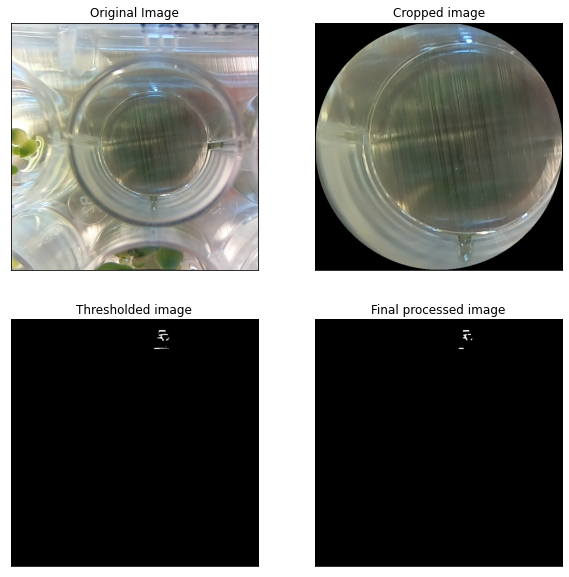

Error in callback <function flush_figures at 0x1379f15e0> (for post_execute):


KeyboardInterrupt: 

In [126]:
#Plant CV pixel counts
pixel_df = return_df_with_image_data(img_data_dir_path, processed_img_dir_path)


### Part 3 - Produce figures

#### Data display option - Growth curves
Connects datapoints averaged across replicates to produce a line of growth against time. 

In [137]:
#Green pixel counting pixel counts
analysis_df = generate_analysis_df(pixel_df, data_df)
print(analysis_df)

Lm5500, 150 mM Salt, Day 0
[16614.0, 20346.0, 22321.0, 11696.0]
Lm5500, 150 mM Salt, Day 1
[21845.0, 12708.0, 22557.0, 511207.0]
Lm5500, 150 mM Salt, Day 4
[22649.0, 554609.0, 12166.0, 525229.0]
Lm5500, 150 mM Salt, Day 6
[15162.0, 22632.0, 12311.0, 23229.0]
Lm5500, 150 mM Salt, Day 9
[18187.0, 15946.0, 9254.0, 9020.0]
Lm5500, 50 mM Salt, Day 0
[9712.0, 21655.0, 17203.0, 14199.0]
Lm5500, 50 mM Salt, Day 1
[29263.0, 21641.0, 15187.0, 11635.0]
Lm5500, 50 mM Salt, Day 4
[35644.0, 32156.0, 21564.0, 19515.0]
Lm5500, 50 mM Salt, Day 6
[25464.0, 28271.0, 36540.0, 49093.0]
Lm5500, 50 mM Salt, Day 9
[66551.0, 52761.0, 39628.0, 19322.0]
Lm5500, Mock, Day 0
[22181.0, 22826.0, 21581.0, 26163.0]
Lm5500, Mock, Day 1
[24241.0, 23424.0, 34223.0, 25651.0]
Lm5500, Mock, Day 4
[38479.0, 501191.0, 66152.0, 1227.0]
Lm5500, Mock, Day 6
[109868.0, 64517.0, 82060.0]
Lm5500, Mock, Day 9
[113504.0, 152113.0, 183441.0, 123.0]
Lm8627, 150 mM Salt, Day 0
[10551.0, 37969.0, 31558.0, 9916.0]
Lm8627, 150 mM Salt, Day

/var/folders/nc/pbz0zfmn5tq28c62lh3svf880000gn/T/ipykernel_6168/49869992.py:133: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


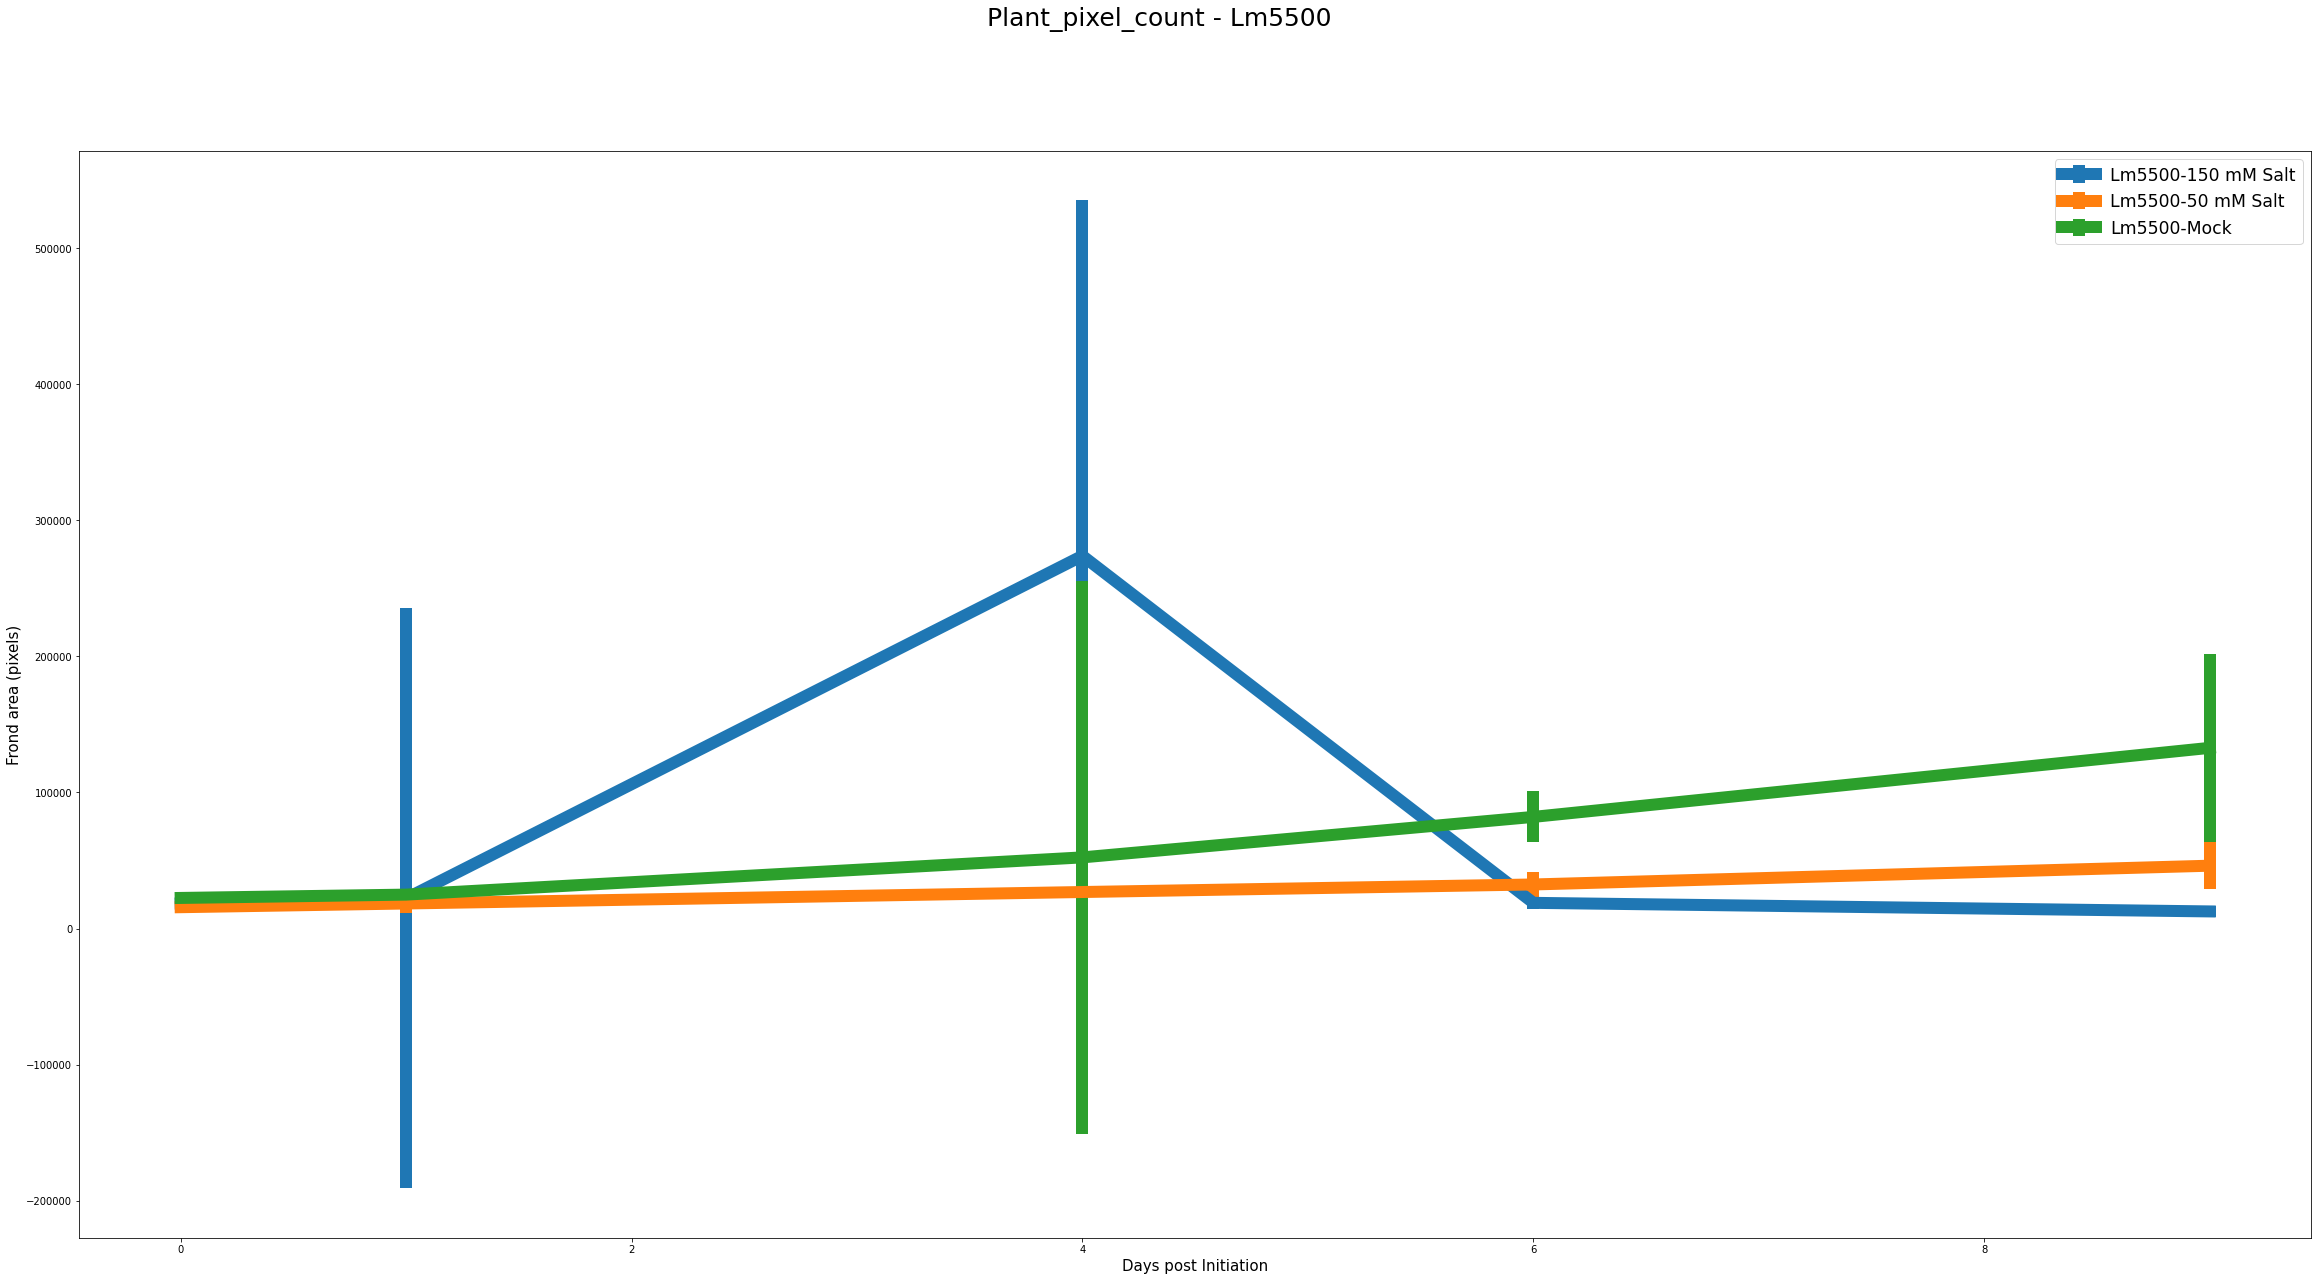

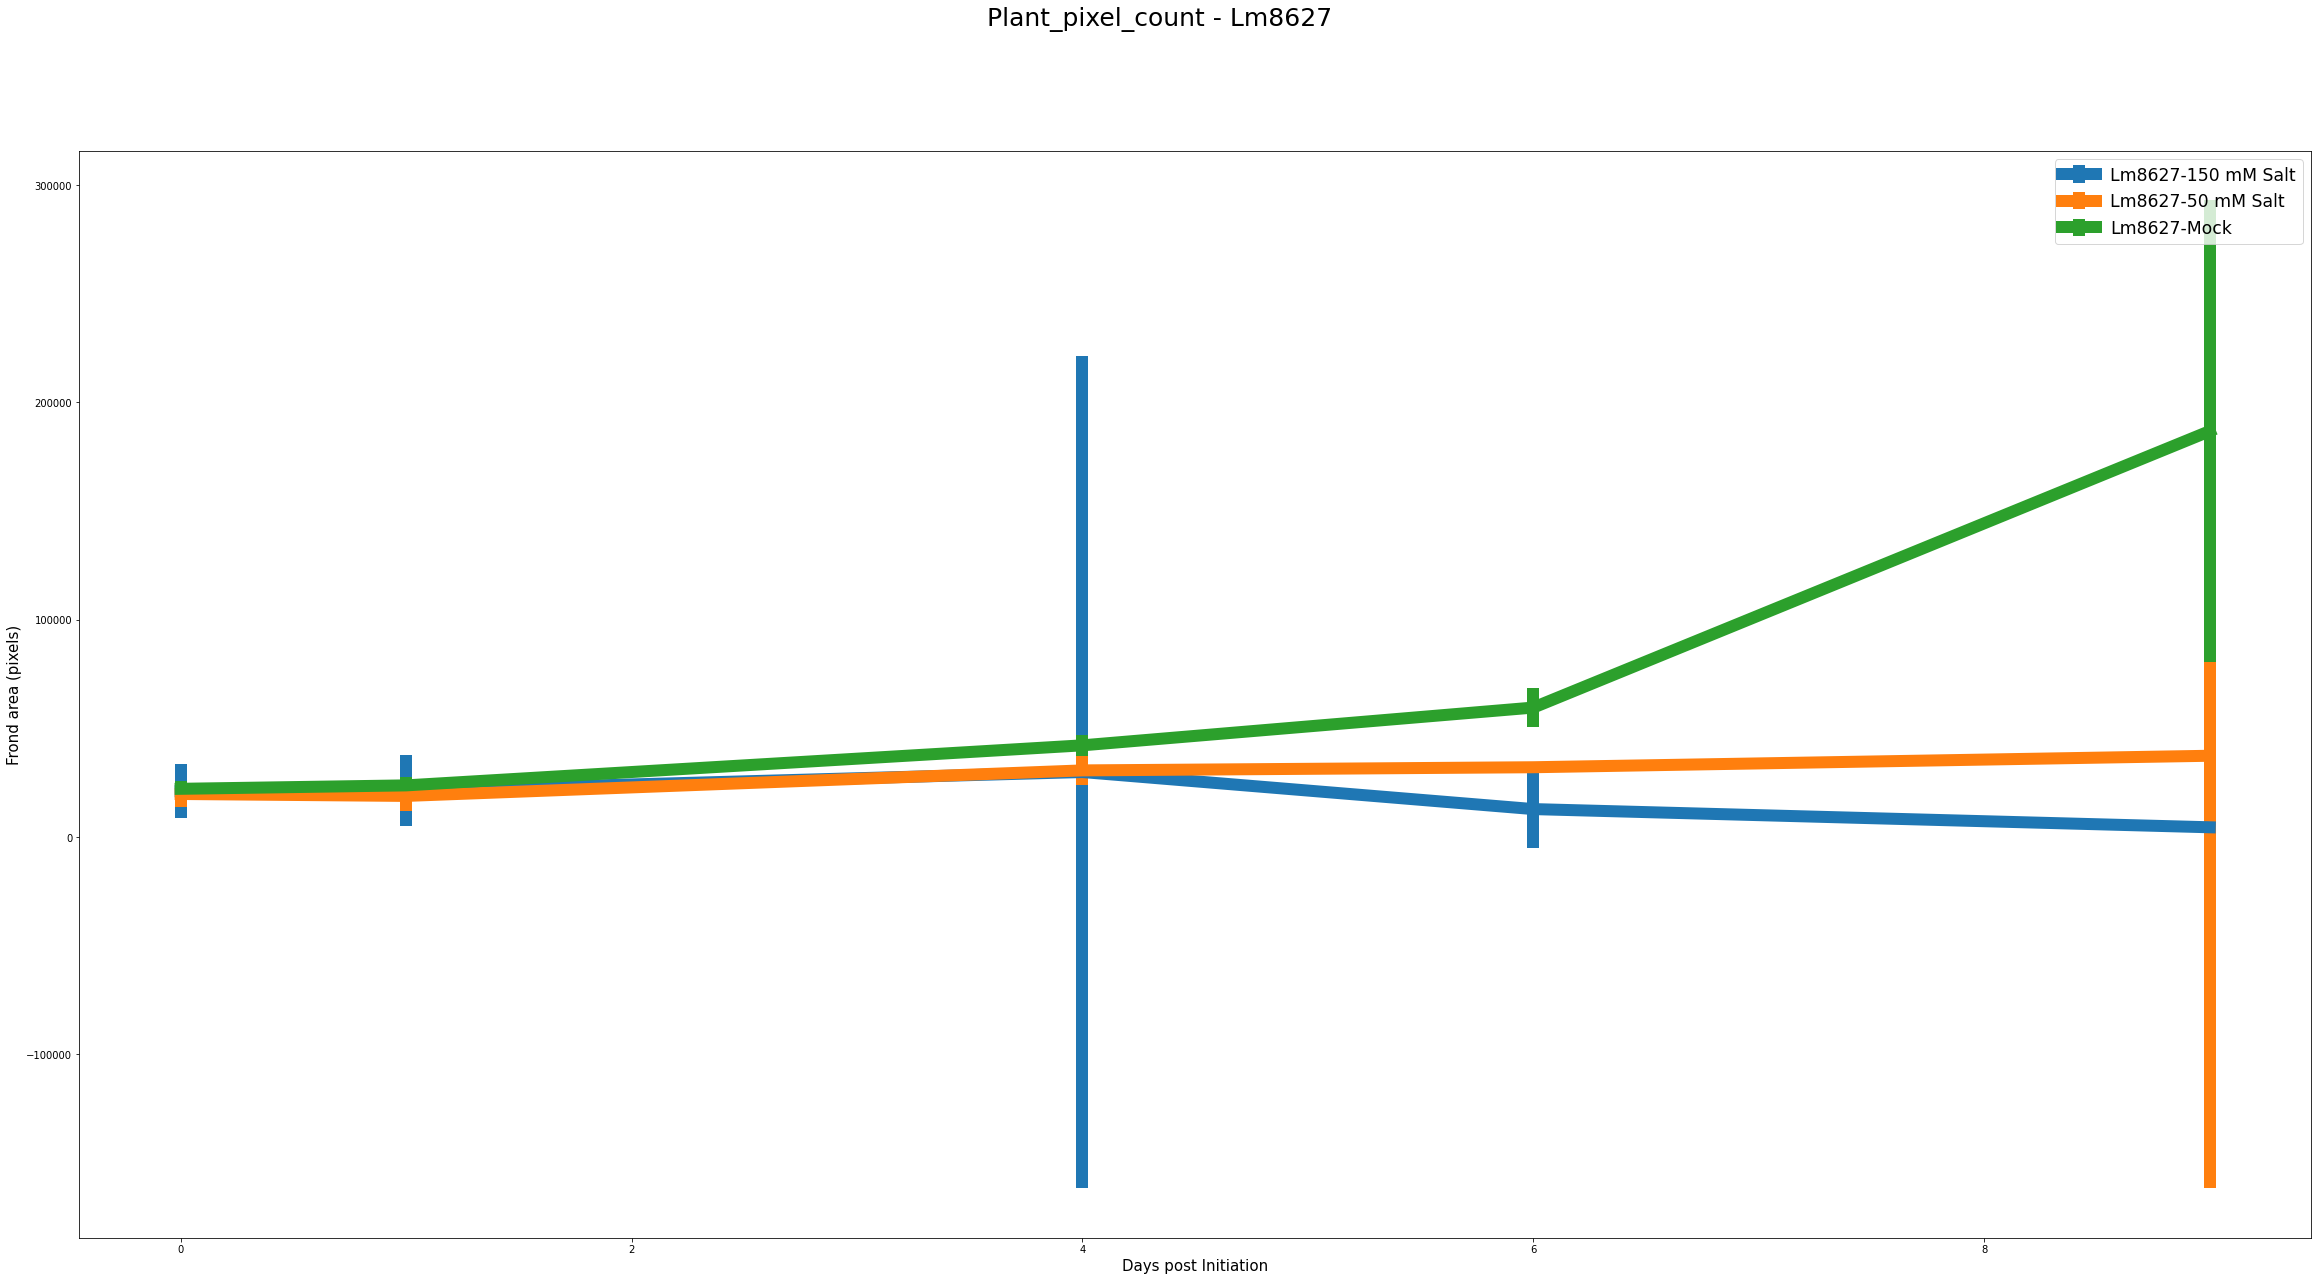

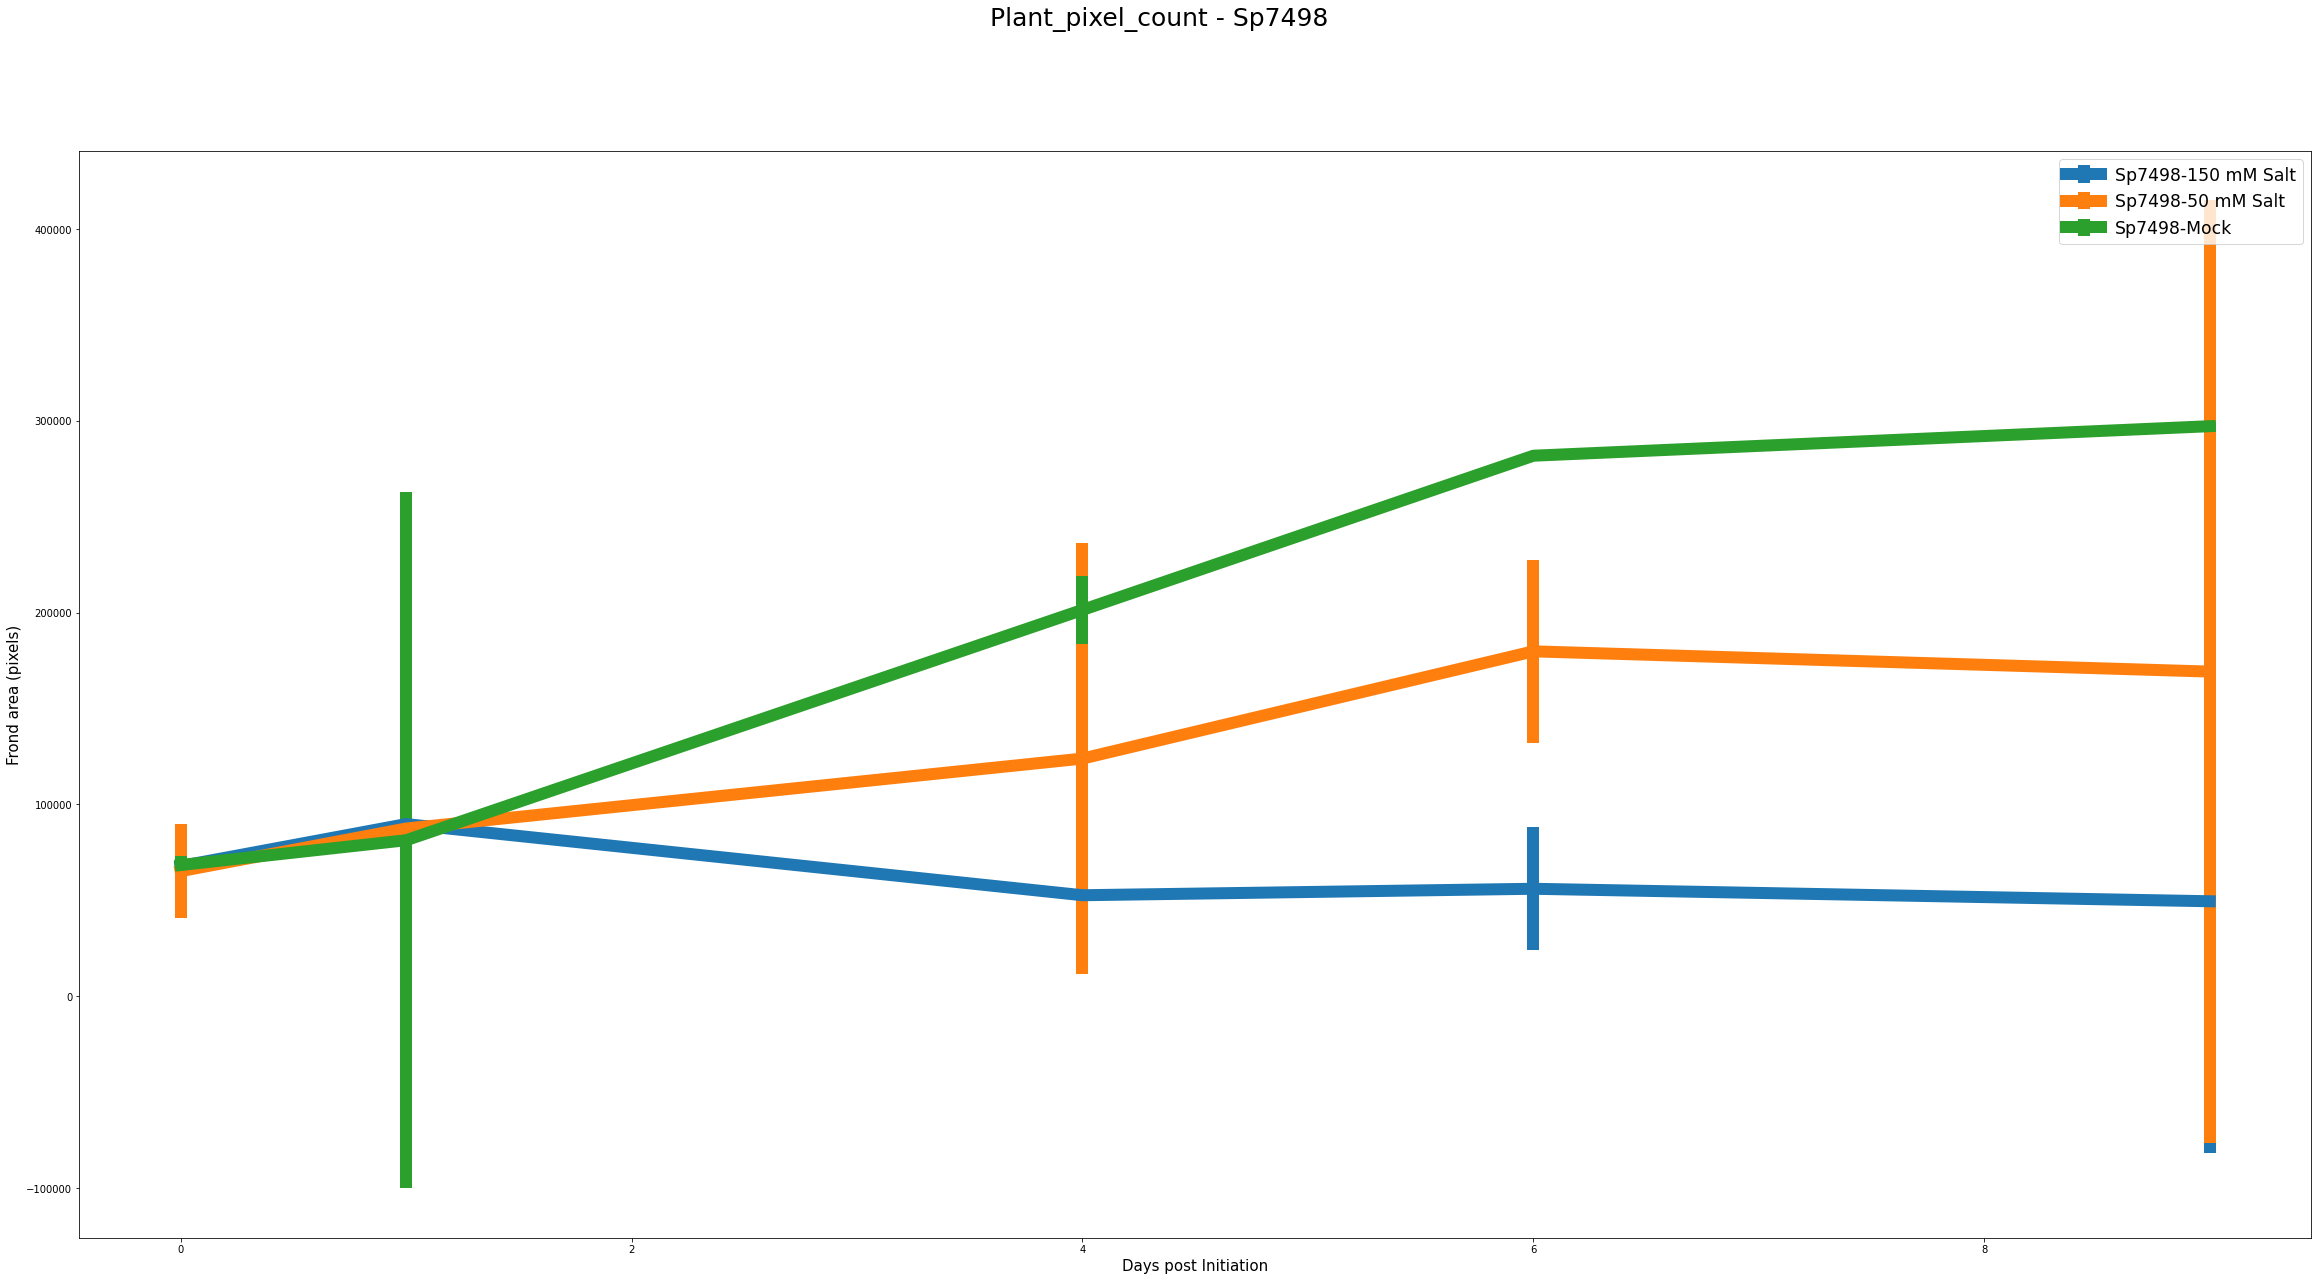

In [138]:
plot_media_by_genotype(analysis_df, "Plant_pixel_count")

### Data display option - Dose Response curve
Note that this analylsis only makes sense if your experiment involved a series of media conditions along a quantitative axis (i.e. concentration of a particular additive). 

In [139]:
days = list(data_df['dpi'])
days_as_set = [*set(days)]
print(days_as_set)
max_days = max(days_as_set)
min_days = min(days_as_set)
days_range = max_days-min_days
reps = days = list(data_df['replicate'])
rep_set = [*set(reps)]
print(rep_set)


[0, 1, 4, 6, 9]
[1, 2, 3, 4]


In [141]:
genotype_df = data_df.groupby(['genotype']) #Returns a list of tuples with [0] being the group key and [1] the dataframe
for g in genotype_df:
    print(g[1])

                                              filename    plate_well_id  \
1    TestDriveExpt_1_08032022_Plate_1_wellC4_2022-0...  Plate_1_Well_C4   
2    TestDriveExpt_1_08032022_Plate_1_wellA2_2022-0...  Plate_1_Well_A2   
9    TestDriveExpt_1_08032022_Plate_1_wellB6_2022-0...  Plate_1_Well_B6   
10   TestDriveExpt_1_08032022_Plate_1_wellC3_2022-0...  Plate_1_Well_C3   
11   TestDriveExpt_1_08032022_Plate_1_wellC4_2022-0...  Plate_1_Well_C4   
17   TestDriveExpt_1_08032022_Plate_1_wellC3_2022-0...  Plate_1_Well_C3   
18   TestDriveExpt_1_08032022_Plate_1_wellB6_2022-0...  Plate_1_Well_B6   
23   TestDriveExpt_1_08032022_Plate_1_wellB6_2022-0...  Plate_1_Well_B6   
24   TestDriveExpt_1_08032022_Plate_1_wellC3_2022-0...  Plate_1_Well_C3   
25   TestDriveExpt_1_08032022_Plate_1_wellC4_2022-0...  Plate_1_Well_C4   
29   TestDriveExpt_1_08032022_Plate_1_wellD3_2022-0...  Plate_1_Well_D3   
33   TestDriveExpt_1_08032022_Plate_1_wellC2_2022-0...  Plate_1_Well_C2   
34   TestDriveExpt_1_0803

In [149]:


#Create new dictionary
dose_response_dict = {'genotype': [], 'media' : [], 'RGRs' : [], 'RGR_median': [],'error': []}


#TODO - FINISH THIS
#Populate dictionary with values from dataframe constructed above
genotype_df = data_df.groupby(['genotype']) #Returns a list of tuples with [0] being the group key and [1] the dataframe
for g in genotype_df:
    media_df = g[1].groupby(['media'])
    for m in media_df:
        rgrs =[]
        for n in rep_set:
#             print(f"{g[0]},{m[0]},{n}")
            rep_n_rows = m[1].loc[m[1]['replicate'] == n]
            min_pixels = list(rep_n_rows.loc[rep_n_rows['dpi'] == min_days]['green_pixels'])
            max_pixels = list(rep_n_rows.loc[rep_n_rows['dpi'] == max_days]['green_pixels'])
            if min_pixels and max_pixels: #Deals with situation where data are missing for Day 0 or 9.
                if min_pixels[0] != 0.0 and max_pixels[0] != 0.0:
                    min_area = min_pixels[0]
                    max_area = max_pixels[0]
#                     print(f"Min{min_area}, Max:{max_area}")
                    rgr = (np.log(max_pixels) - np.log(min_pixels)) / days_range
#                     print(rgr)
                    rgrs.append(rgr)
        dose_response_dict['genotype'].append(g[0])
        dose_response_dict['media'].append(m[0])
        dose_response_dict['RGRs'].append(rgrs)
        dose_response_dict['RGR_median'].append(np.median(rgrs))
        dose_response_dict['error'].append(np.std(rgrs))
        

#         if m['dpi'] == min_days:
#             min_pixels = m['median_green_pixels']
#         if m['dpi'] == max_days:
#         max_pixels = m['median_green_pixels']
   
dose_response_df = pd.DataFrame(dose_response_dict)
print(dose_response_df)

    

#             for d in dpi_df:
#                 dose_response_dict['genotype'].append(list(d[1]['genotype'])[0])
#                 analysis_dict['media'].append(list(d[1]['media'])[0])
#                 analysis_dict['dpi'].append(d[0])
#                 cleaned_up_pixel_vals = remove_outliers(list(d[1]['green_pixels']))
#                 analysis_dict['green_pixels'].append(cleaned_up_pixel_vals)

#     #Create dataframe and add medians and standard deviations. 
#     analysis_df = pd.DataFrame(analysis_dict)
#     analysis_df['median_green_pixels'] = analysis_df.apply(lambda row: np.median(row.green_pixels), axis = 1)
#     analysis_df['stdev_green_pixels'] = analysis_df.apply(lambda row: np.std(row.green_pixels), axis = 1)
#     return(analysis_df)


  genotype        media                                               RGRs  \
0   Lm5500  150 mM Salt  [[-0.03736888058850793], [-0.01246414213629738...   
1   Lm5500   50 mM Salt  [[0.07643134541979732], [0.12474802181751737],...   
2   Lm5500         Mock  [[0.21639409899950873], [0.17821531571775592],...   
3   Lm8627  150 mM Salt  [[-0.21816701187492152], [-0.00569170824974957...   
4   Lm8627   50 mM Salt  [[0.05612273242667835], [0.08584101583927269],...   
5   Lm8627         Mock  [[0.3044637287852158], [0.22131819001268405], ...   
6   Sp7498  150 mM Salt  [[0.024355964640927437], [0.15523107533962804]...   
7   Sp7498   50 mM Salt  [[0.2580498102553255], [0.18227181728196445], ...   
8   Sp7498         Mock     [[0.16346729847441527], [0.18093301009881163]]   

   RGR_median     error  
0   -0.031695  0.020438  
1    0.119281  0.019821  
2    0.197305  0.338575  
3   -0.124991  0.213214  
4    0.070982  0.151212  
5    0.235786  0.036269  
6    0.009099  0.188937  
7    0.1822

/var/folders/nc/pbz0zfmn5tq28c62lh3svf880000gn/T/ipykernel_6168/1930541229.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/nc/pbz0zfmn5tq28c62lh3svf880000gn/T/ipykernel_6168/1930541229.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/var/folders/nc/pbz0zfmn5tq28c62lh3svf880000gn/T/ipykernel_6168/1930541229.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

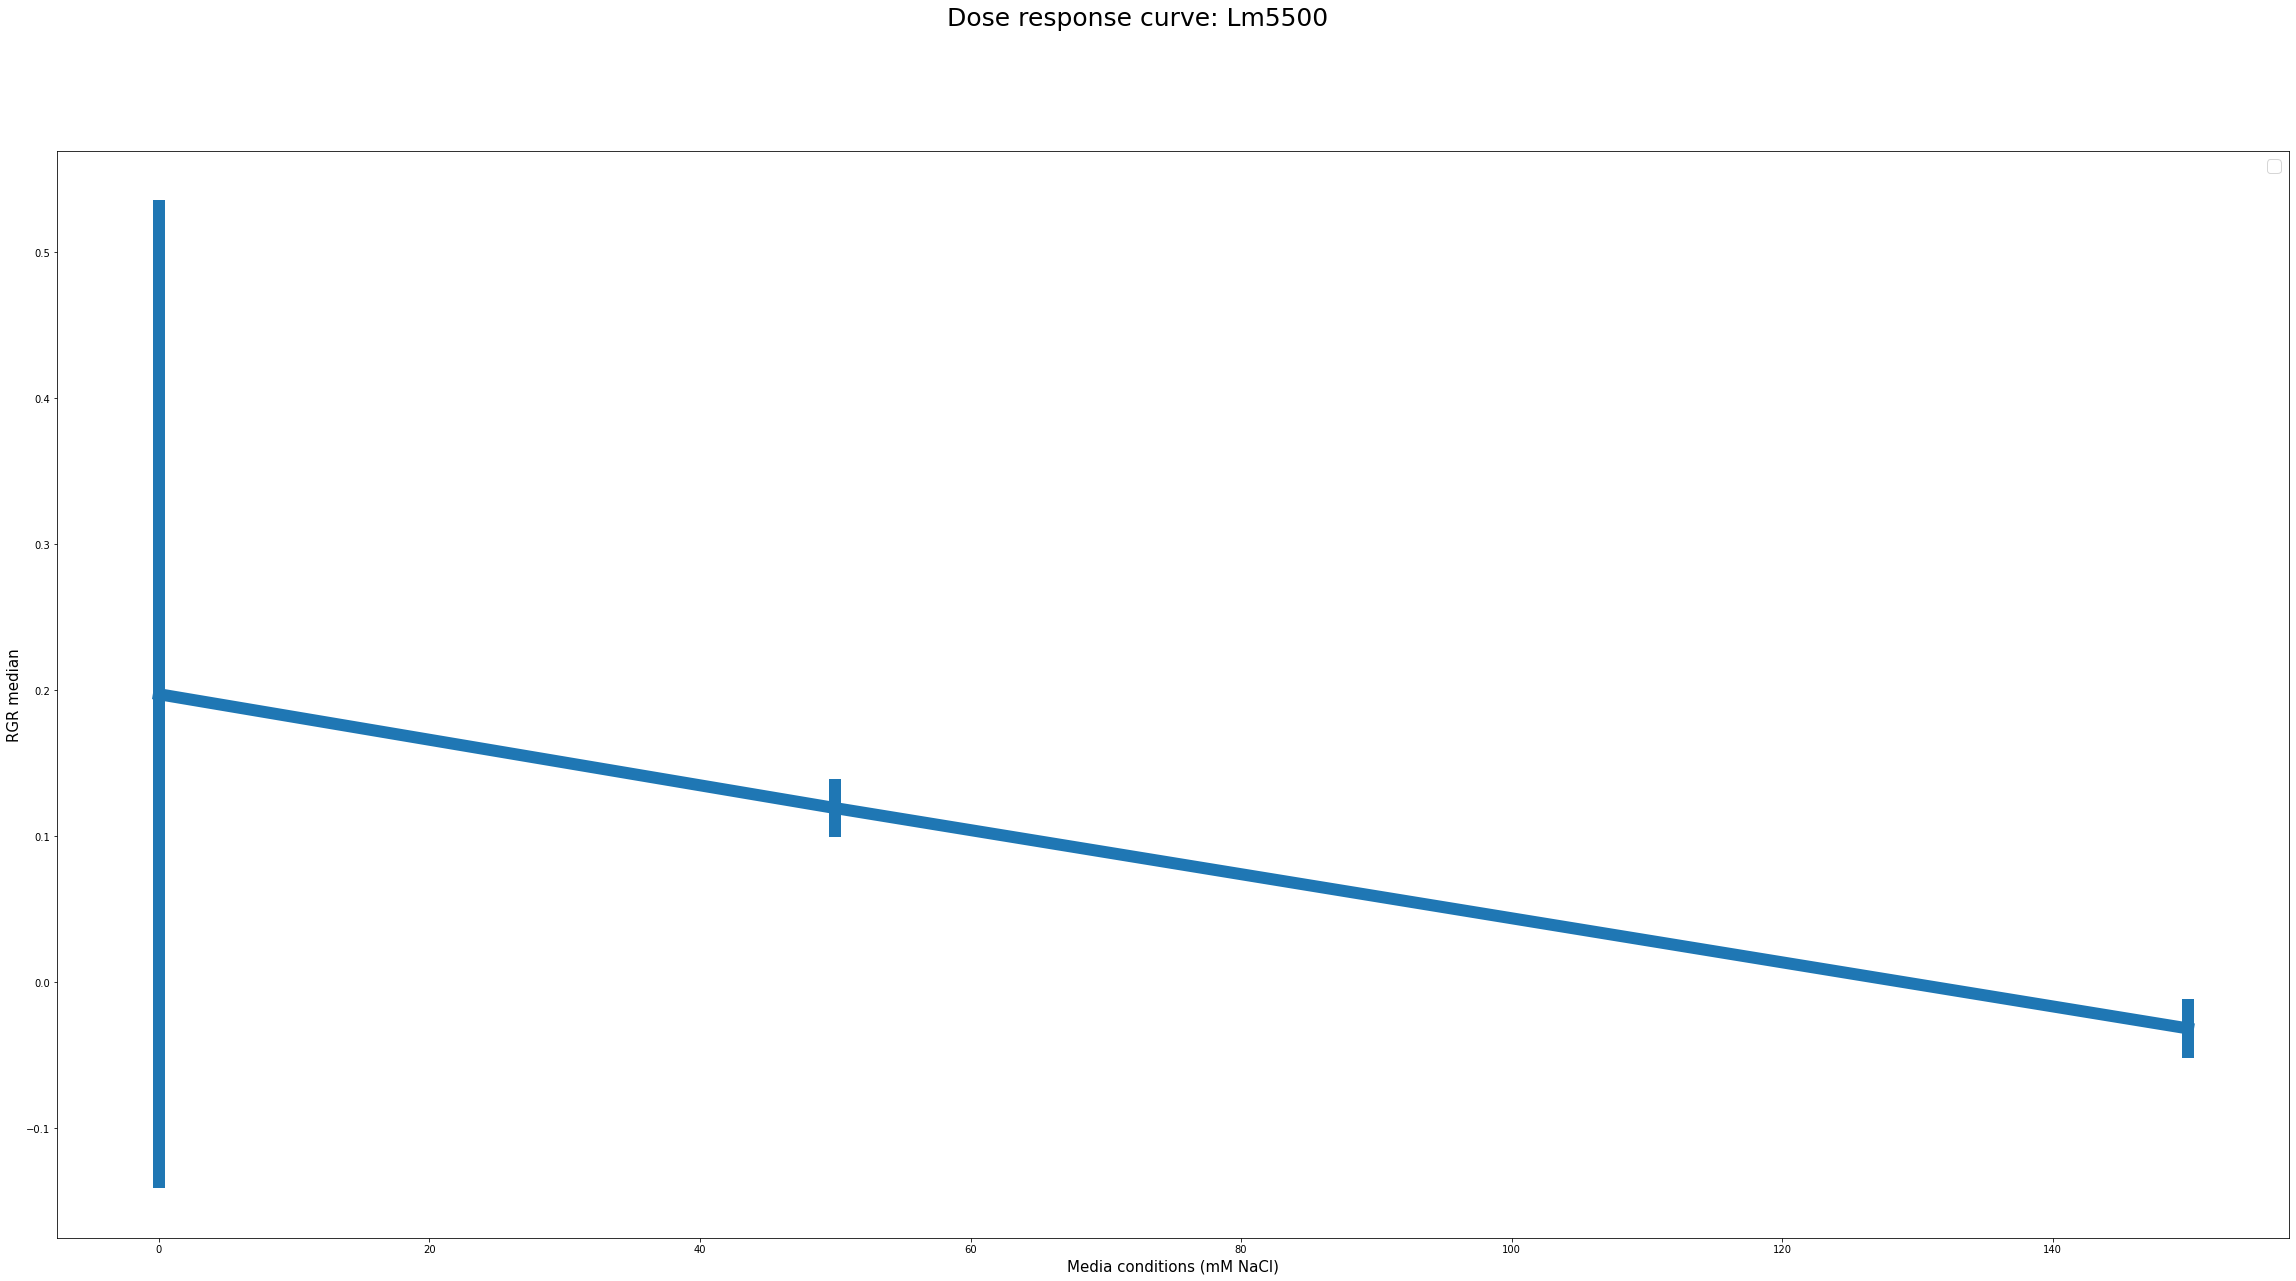

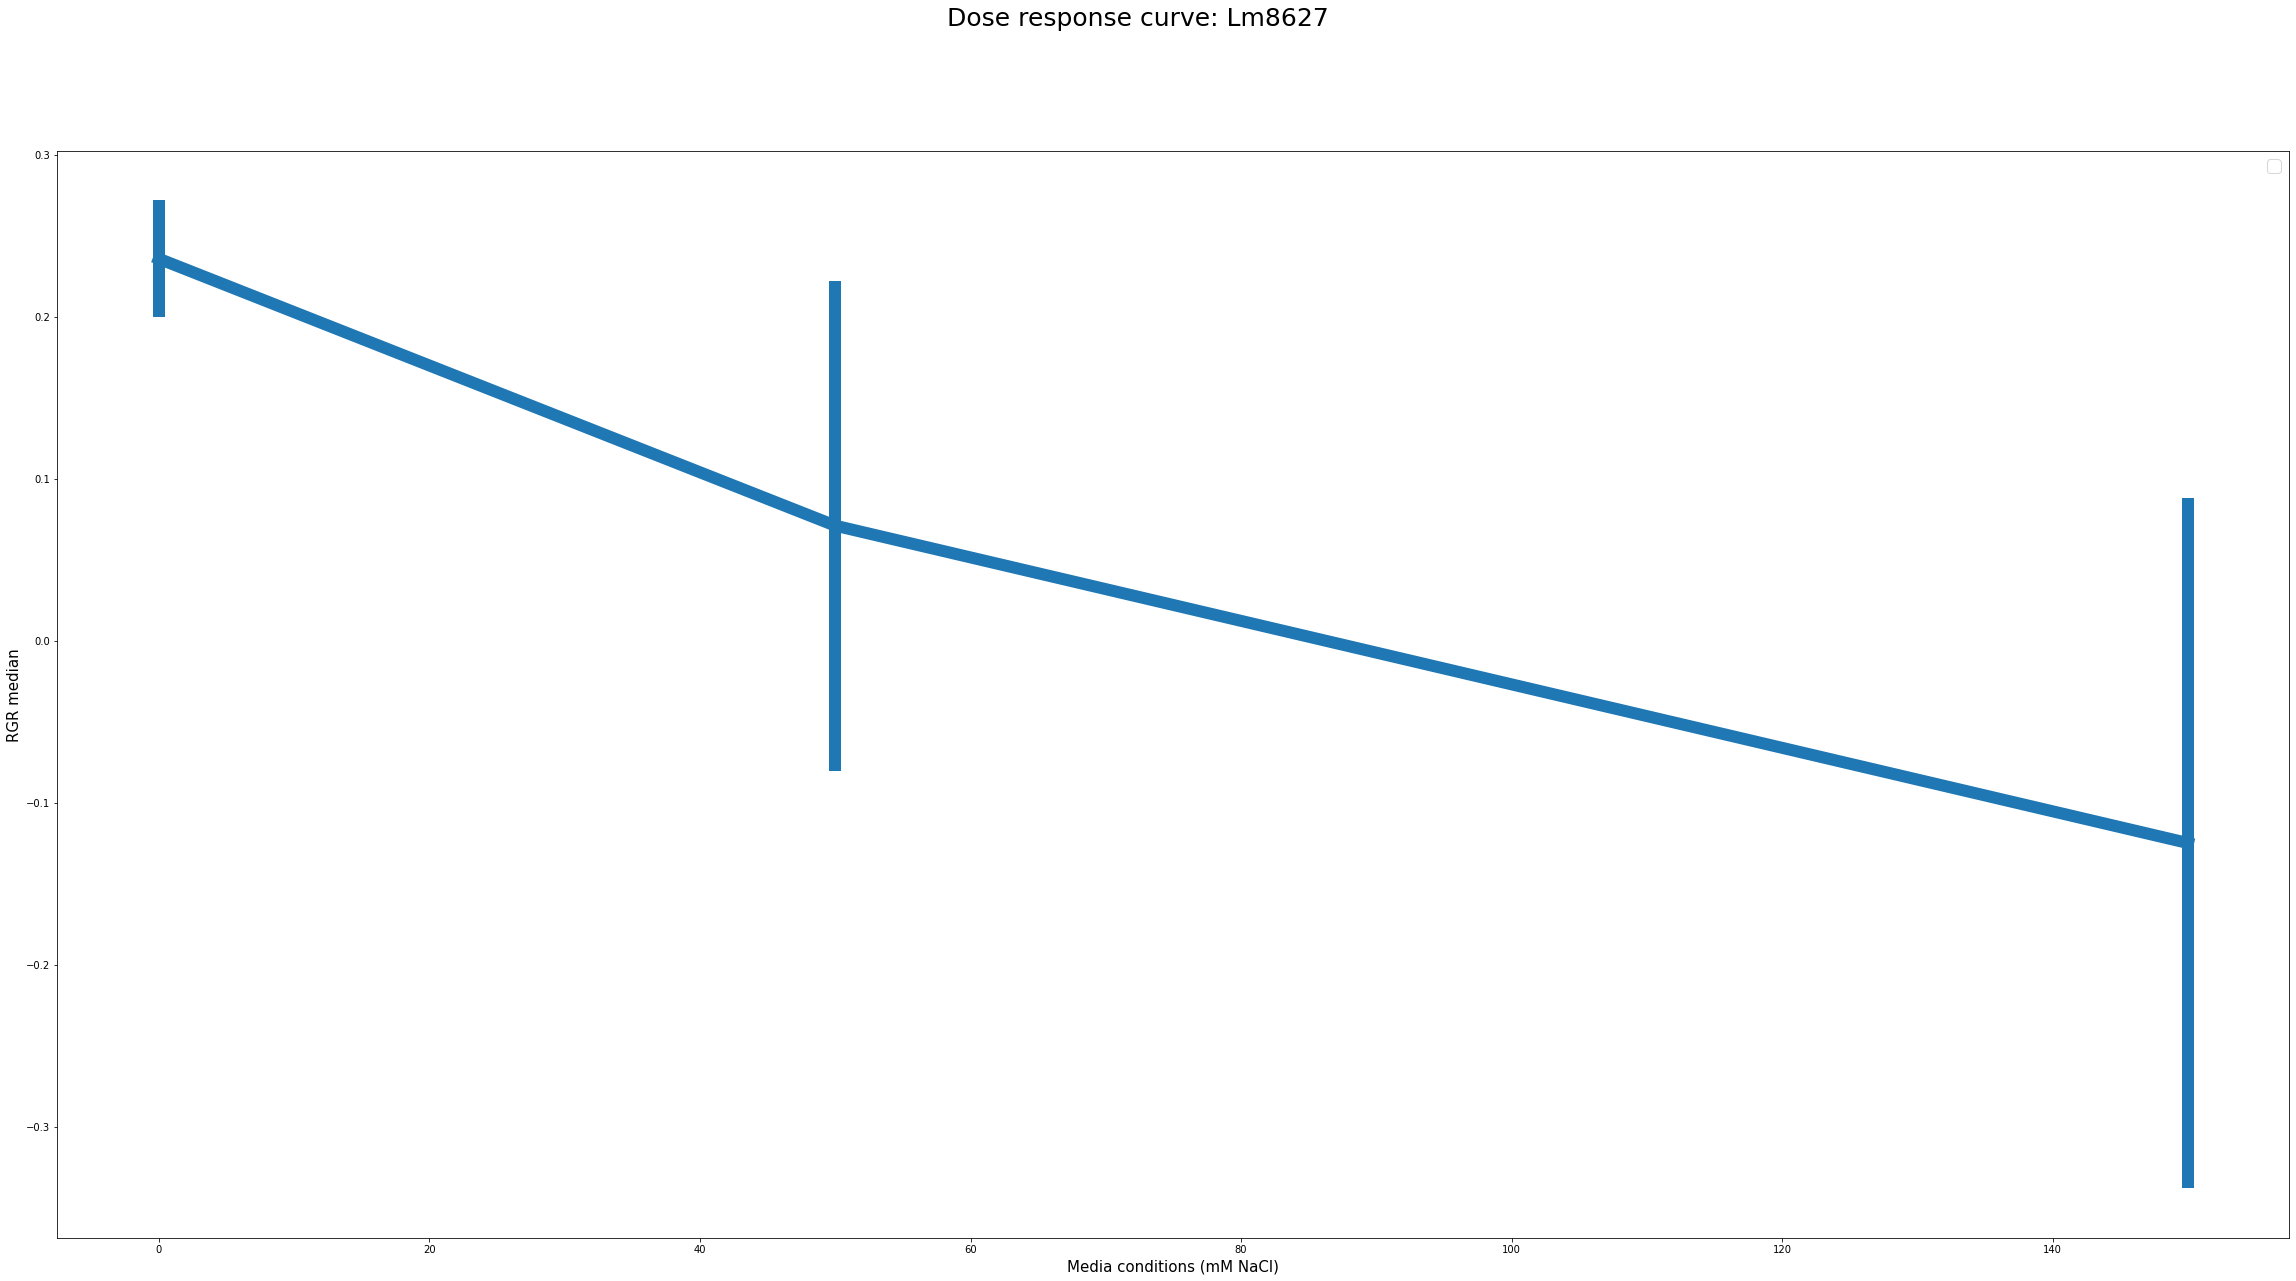

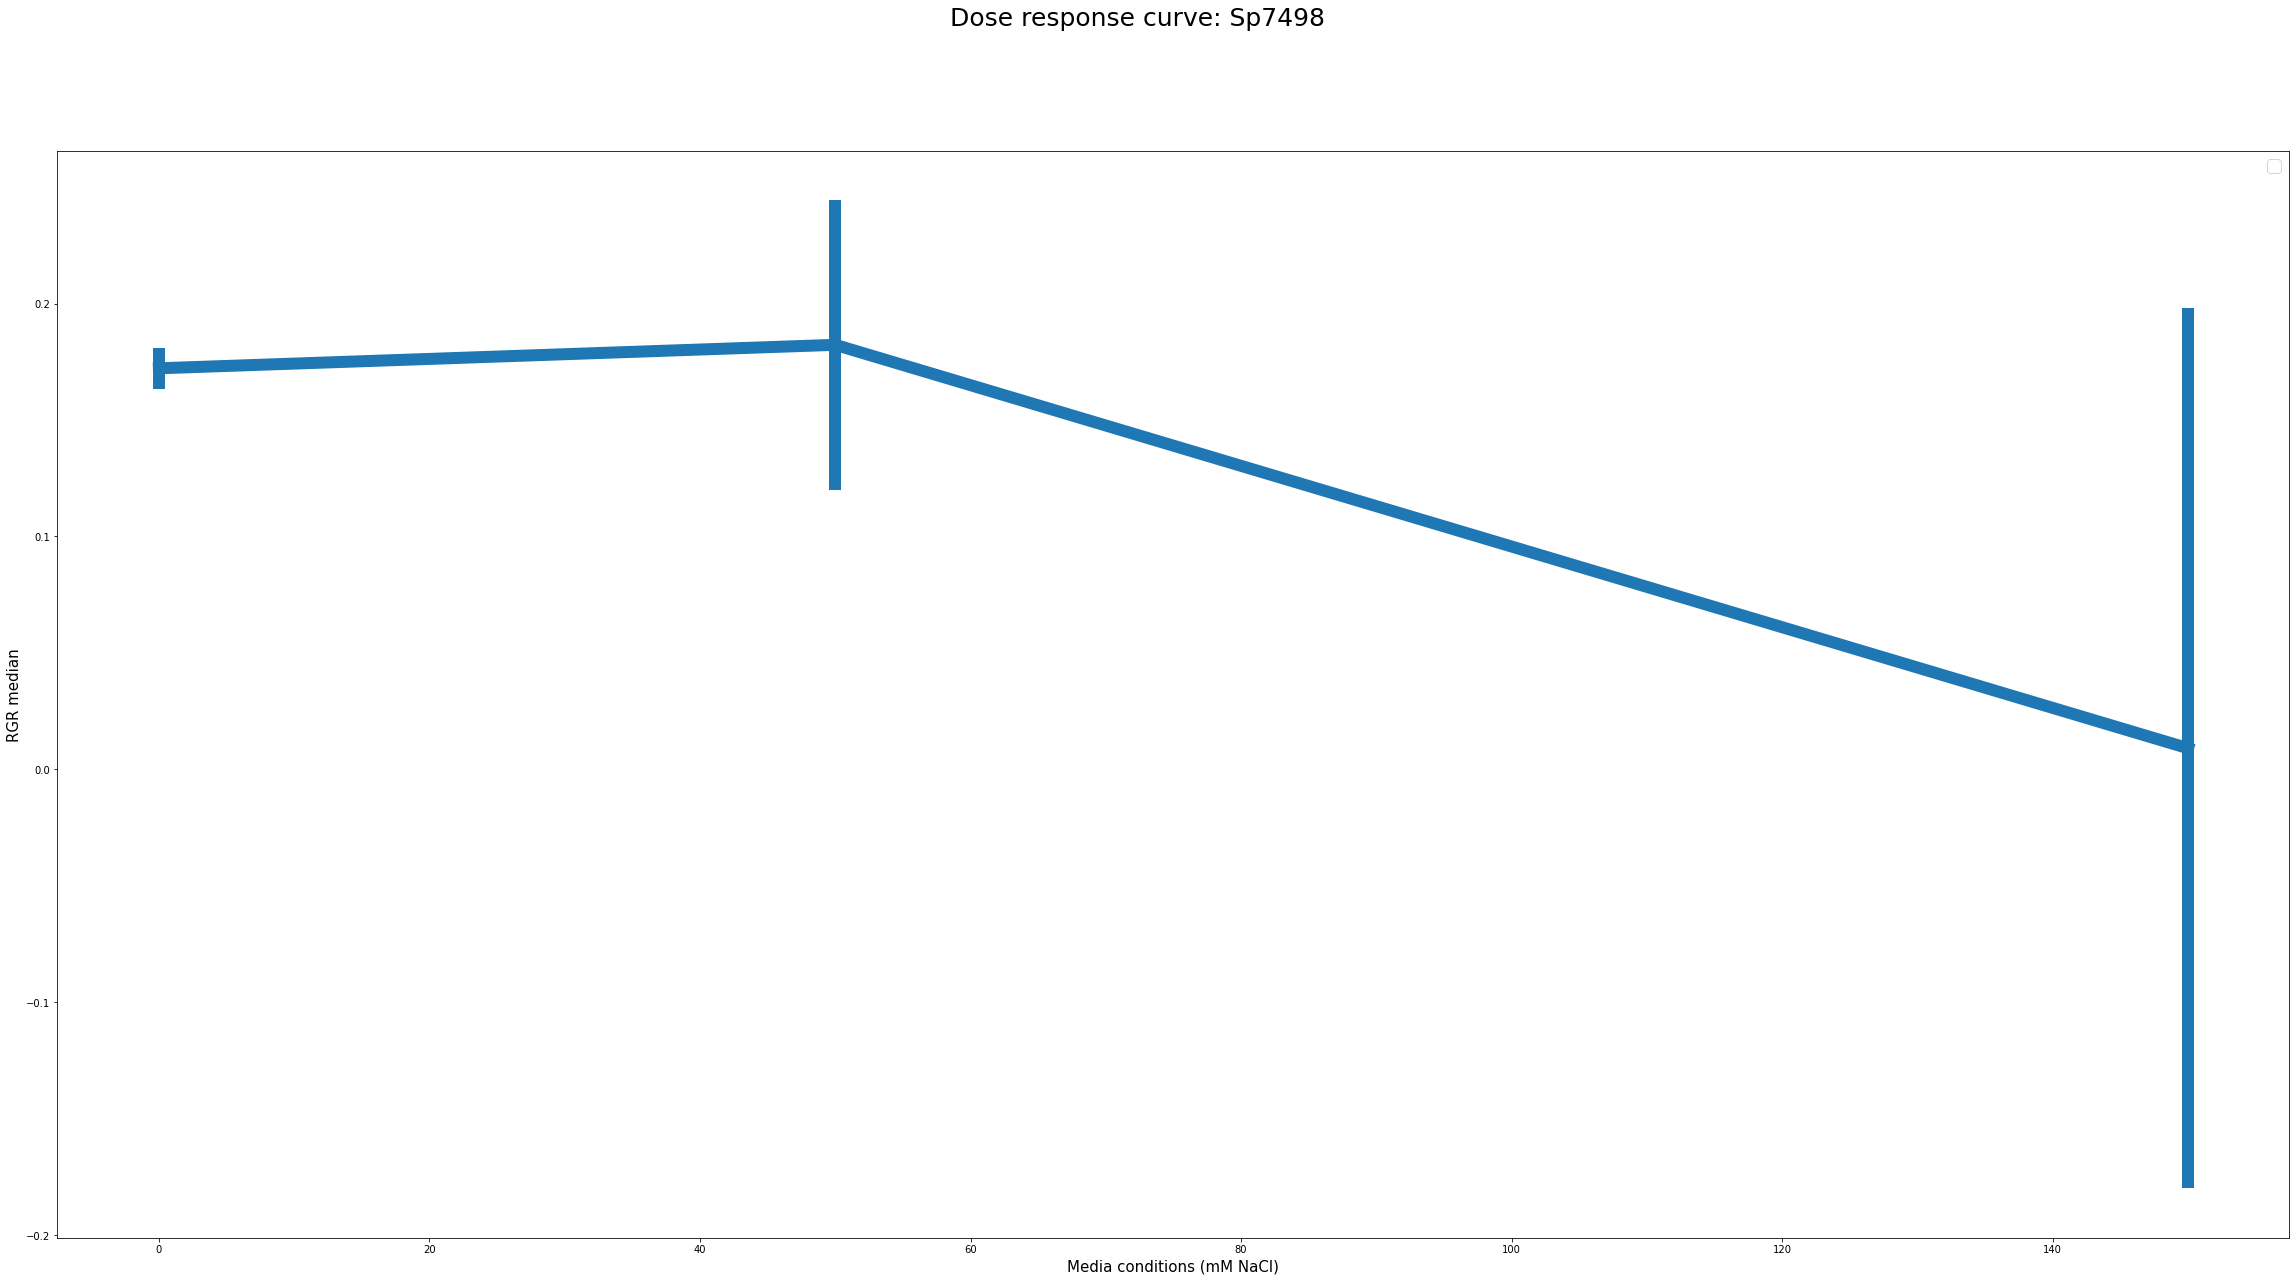

In [153]:
media_conversion_key = {"150 mM Salt": 150, "50 mM Salt": 50, "Mock": 0}

genotype = np.unique(dose_response_df["genotype"])
for g in genotype:
    g_df = dose_response_df[dose_response_df["genotype"] == g]
    g_df['media_cont_var'] = g_df.apply(lambda row: media_conversion_key[row['media']], axis = 1)
    fig, ax = plt.subplots(figsize=(40, 20))
    ax.errorbar(g_df['media_cont_var'], g_df["RGR_median"],yerr=g_df["error"], linewidth=12)
    ax.legend(loc='upper right',fontsize='xx-large')
    fig.suptitle(f"Dose response curve: {g}", size = 25,wrap = False)
    ax.set_xlabel("Media conditions (mM NaCl)", size = 15)
    ax.set_ylabel("RGR median", size = 15)
    fig.show()

In [195]:
#STEPS:
 #1. Define earliest and latest time points and the distance between them.
 #2. Pull out earliest and latest pixel values for each media/genotype combination. Use them to calculate f(x) below
 #3. Plot those as points
 #4. Calculate and plot line of best fit as below. 
xdata = list(cond_dict.keys())
ydata = [cond_dict[cond][4]/cond_dict[cond][0] for cond in xdata]

def residual(params, x, y):
    def f(x):
        return (params['L']/(1.0 + math.e**(-1*params['k']*(x-params['x0']))))
    yval = f(x)
    errs = [abs((a-b)) for a, b in zip(y, yval)]
    return errs

#depending on the data, need to go thru and refine the starting conditions
p = Parameters()
p.add('L', value=max(ydata))
p.add('k', value=.01)
p.add('x0', value=xdata[-1]/2)


result = minimize(residual,p,args=(xdata,ydata))
result.params.pretty_print()


xvals = np.linspace(0,max(xdata),420)
plt.plot(xvals,(result.params['L'] /(1.0 + math.e**(-1*result.params['k']*(xvals-result.params['x0'])))), c = 'black')

plt.text(230, 1.95, "L = %.2f\nk = %.2f\nx0 = %.2f" % (result.params['L'], result.params['k'], result.params['x0']))
plt.xlabel("NaCl Concentration (mM)")
plt.ylabel("Normalized Growth Over 10 Days")
plt.scatter(xdata,ydata, c = 'black')
plt.savefig("dose_response_4c.jpg")


NameError: name 'cond_dict' is not defined

#### Part 2


In [ ]:
#